# Exploring CVXPY

Exploring CVXPY for L1-regularized complex least squares

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from cvxpy import *
import numpy as np

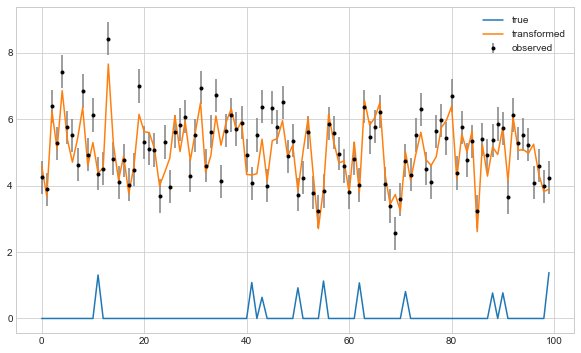

In [2]:
def make_data(N=100, M=100, K=10, sigma=0.5, rseed=543534, cplx=False):
    rand = np.random.RandomState(rseed)
    A = rand.rand(N, M)
    x = np.zeros(M)
    x[rand.randint(0, M, K)] = 0.5 + rand.rand(K)
    noise = rand.randn(N)
    
    if cplx:
        A = A * np.exp(-2j * np.pi * rand.rand(N, M))
        x = x * np.exp(-2j * np.pi * rand.rand(M))
        noise = noise * np.exp(-2j * np.pi * rand.rand(N))
    
    y = np.dot(A, x) + sigma * noise
    return A, x, y

A, x, y = make_data()
t = np.arange(len(x))

plt.figure(figsize=(10, 6))
plt.plot(t, x, label='true')
plt.plot(t, A.dot(x), label='transformed')
plt.errorbar(t, y, 0.5, fmt='.k', ecolor='gray', label='observed')

plt.legend();

## Simple Least Squares

In [3]:
# Problem data. Use very small noise here
A, x_true, y = make_data(N=100, M=100, K=10, sigma=0.003)

# Construct the problem.
x = Variable(A.shape[1])
objective = sum_squares(A*x - y)
prob = Problem(Minimize(objective))

# Solve the problem
prob.solve()
x_solution = x.value
print("Problem Status: {0}".format(prob.status))

Problem Status: optimal


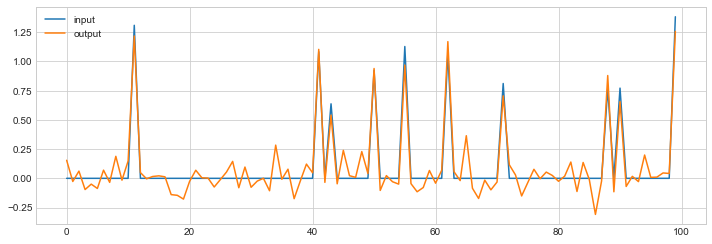

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(x_true, label='input')
plt.plot(np.asarray(x_solution).ravel(), label='output')
plt.legend();

## Least Squares with L1 Regularization

In [5]:
# Problem data. Note higher noise level
A, x_true, y = make_data(N=100, M=100, K=10, sigma=0.2)

# gamma must be positive due to DCP rules.
gamma = Parameter(sign="positive")

# Construct the problem.
x = Variable(A.shape[1])
error = sum_squares(A*x - y)
objective = Minimize(error + gamma*norm(x, 1))
prob = Problem(objective)

gamma.value = 1.0
prob.solve()
print("Problem Status: {0}".format(prob.status))

x_solution = x.value

Problem Status: optimal


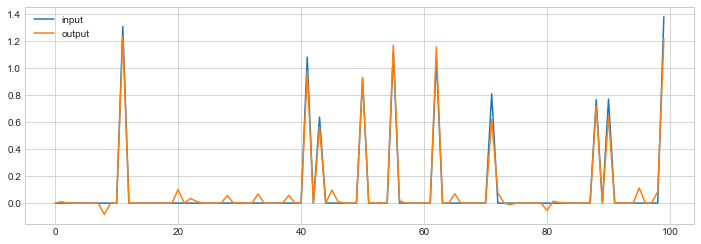

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(x_true, label='input')
plt.plot(np.asarray(x_solution).ravel(), label='output')
plt.legend();

## Complex Least Squares with L1 regularization

Here we follow Section VI(D) of [An Interior-Point Method for Large-Scale L1-Regularized Least Squares](http://web.stanford.edu/~boyd/papers/pdf/l1_ls.pdf)

We regularize on a latent parameter *u* which gives an upper-limit on the magnitude of x.

In [7]:
# Create complex data
A, x_true, y = make_data(N=100, M=100, K=10, sigma=0.2, cplx=True)
N, M = A.shape

# objective is ||Ax - y||^2 + gamma |u|_1
#  with constraint abs(x_i) < u_i
# for complex A, x, y and real u

Ar, Ai = A.real, A.imag
yr, yi = y.real, y.imag

xr = Variable(M)
xi = Variable(M)
u = Variable(M)
gamma = Parameter(sign="positive")

error = sum_squares(Ar*xr - Ai*xi - yr) + sum_squares(Ai*xr + Ar*xi - yi)
objective = Minimize(error + gamma*norm(u, 1))
constraints = [norm(hstack(xr, xi), 2, axis=1) <= u]

gamma.value = 1.0
prob = Problem(objective, constraints)
prob.solve()
print("Problem Status: {0}".format(prob.status))

x_solution = np.array(xr.value).ravel() + 1j * np.array(xi.value).ravel() 
u_solution = np.array(u.value).ravel()

Problem Status: optimal


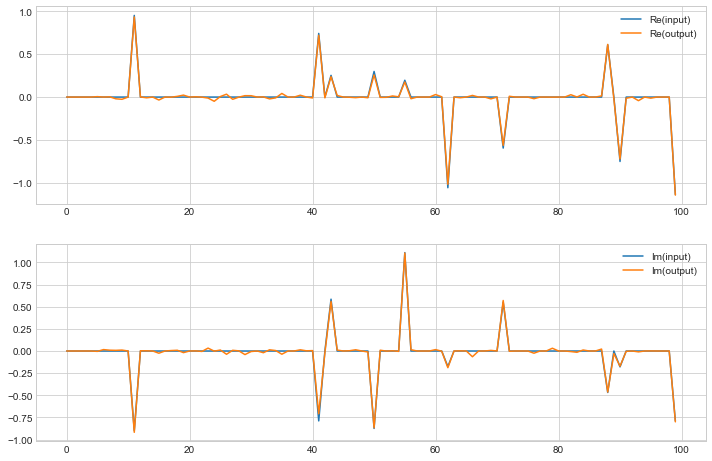

In [8]:
fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].plot(x_true.real, label='Re(input)')
ax[0].plot(x_solution.real, label='Re(output)')
#ax[0].plot(u_solution, label='u value')
ax[0].legend()

ax[1].plot(x_true.imag, label='Im(input)')
ax[1].plot(x_solution.imag, label='Im(output)')
#ax[1].plot(u_solution, label='u value')
ax[1].legend()

plt.legend();